In [2]:
import torch
import linear_rep_geometry as lrg

device = torch.device("cuda:0")

g = torch.load('tmp_matrices/g.pt').to(device)
concept_g = torch.load('tmp_matrices/concept_g.pt').to(device)
sqrt_Cov_gamma = torch.load("tmp_matrices/sqrt_Cov_gamma.pt").to(device)
W, d = g.shape

concept_names = []
with open('tmp_matrices/concept_names.txt', 'r') as f:
    for line in f.readlines():
        concept_names.append(line.strip())

/home/itai/research/linear_rep_geometry/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_166362/3088499159.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you

In [3]:
print(g.shape, "：（語彙サイズ，隠れ層の次元数）")
print(concept_g.shape, "：（counter factualの概念のファイル数，隠れ層の次元数）")

torch.Size([128256, 3072]) ：（語彙サイズ，隠れ層の次元数）
torch.Size([10, 3072]) ：（counter factualの概念のファイル数，隠れ層の次元数）


In [4]:
# filenames = ["paired_contexts/en-fr.jsonl",
#              "paired_contexts/fr-de.jsonl",
#              "paired_contexts/fr-es.jsonl",
#              "paired_contexts/es-de.jsonl"]

filenames = []
with open(f"tmp_matrices/filenames.txt", "r") as f:
    for line in f.readlines():
        filenames.append(line.strip())
filenames

['/home/itai/research/linear_rep_geometry/data/ValueNet/schwartz/pos2neg/norm_sentence_structure/[Achievement(Positive) - Achievement(Negative)].txt',
 '/home/itai/research/linear_rep_geometry/data/ValueNet/schwartz/pos2neg/norm_sentence_structure/[Benevolence(Positive) - Benevolence(Negative)].txt',
 '/home/itai/research/linear_rep_geometry/data/ValueNet/schwartz/pos2neg/norm_sentence_structure/[Conformity(Positive) - Conformity(Negative)].txt',
 '/home/itai/research/linear_rep_geometry/data/ValueNet/schwartz/pos2neg/norm_sentence_structure/[Hedonism(Positive) - Hedonism(Negative)].txt',
 '/home/itai/research/linear_rep_geometry/data/ValueNet/schwartz/pos2neg/norm_sentence_structure/[Power(Positive) - Power(Negative)].txt',
 '/home/itai/research/linear_rep_geometry/data/ValueNet/schwartz/pos2neg/norm_sentence_structure/[Security(Positive) - Security(Negative)].txt',
 '/home/itai/research/linear_rep_geometry/data/ValueNet/schwartz/pos2neg/norm_sentence_structure/[Self-direction(Positiv

In [10]:
import re

concept2idx = {}
idx2concept = {}
pattern = r'\[(.*?)\('
for idx, filename in enumerate(filenames):
    match1 = re.search(pattern, filenames[idx].split("/")[-1])
    concept_name = match1.group(1)
    concept2idx[concept_name] = idx
    idx2concept[idx] = concept_name

In [6]:
import random 
from tqdm import tqdm
import json
import matplotlib.pyplot as plt

def get_lambda_pairs(filename, num_eg=20, file_format='json'):
    lambdas_0 = []
    lambdas_1 = []
    
    count = 0
    with open(filename, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        
        # Sample data if needed
        if len(lines) > 1000:
            lines = random.sample(lines, 1000)
        
        for line in tqdm(lines):
            if count >= num_eg:
                break
                
            if file_format == 'json':
                data = json.loads(line.strip())
                text_0 = [s.strip(" " + data["word0"]) for s in data["contexts0"]]
                text_1 = [s.strip(" " + data["word1"]) for s in data["contexts1"]]
            elif file_format == 'txt':
                parts = line.strip().split('\t')
                text_0 = [parts[0]]
                text_1 = [parts[1]]
            
            lambda_0 = lrg.get_embeddings(text_0)
            lambda_1 = lrg.get_embeddings(text_1)
            
            if lambda_0 is not None and lambda_1 is not None:
                lambdas_0.append(lambda_0)
                lambdas_1.append(lambda_1)
                count += 1
    return torch.cat(lambdas_0), torch.cat(lambdas_1)

In [7]:
lrg.load_model()

Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]


In [15]:
idx = 0
concept_name = idx2concept[idx]

print(f"{concept_name=}, {idx=}")

lambda_0, lambda_1 = get_lambda_pairs(filenames[idx], file_format="txt")

concept_name='Achievement', idx=0


  2%|▏         | 20/1000 [00:01<01:27, 11.18it/s]


In [ ]:
def hist_measurement(
    lambda_0,
    lambda_1,
    concept,
    concept_names,
    base="English",
    target="French",
    alpha=0.5,
):
    fig, axs = plt.subplots(7, 4, figsize=(16, 20))

    axs = axs.flatten()

    for i in range(concept.shape[0]):
        W0 = lambda_0 @ concept[i]
        W1 = lambda_1 @ concept[i]

        axs[i].hist(W0.cpu().numpy(), bins=25, alpha=alpha, label=base, density=True)
        axs[i].hist(W1.cpu().numpy(), bins=25, alpha=alpha, label=target, density=True)
        axs[i].set_yticks([])
        axs[i].set_title(f"{concept_names[i]}")

    handles, labels = axs[0].get_legend_handles_labels()
    axs[concept.shape[0]].legend(handles, labels, loc="center")
    axs[concept.shape[0]].axis("off")

    plt.tight_layout()
    # plt.savefig(
    #     "figures/appendix_measurement_" + base + "-" + target + ".png",
    #     bbox_inches="tight",
    # )
    plt.show()

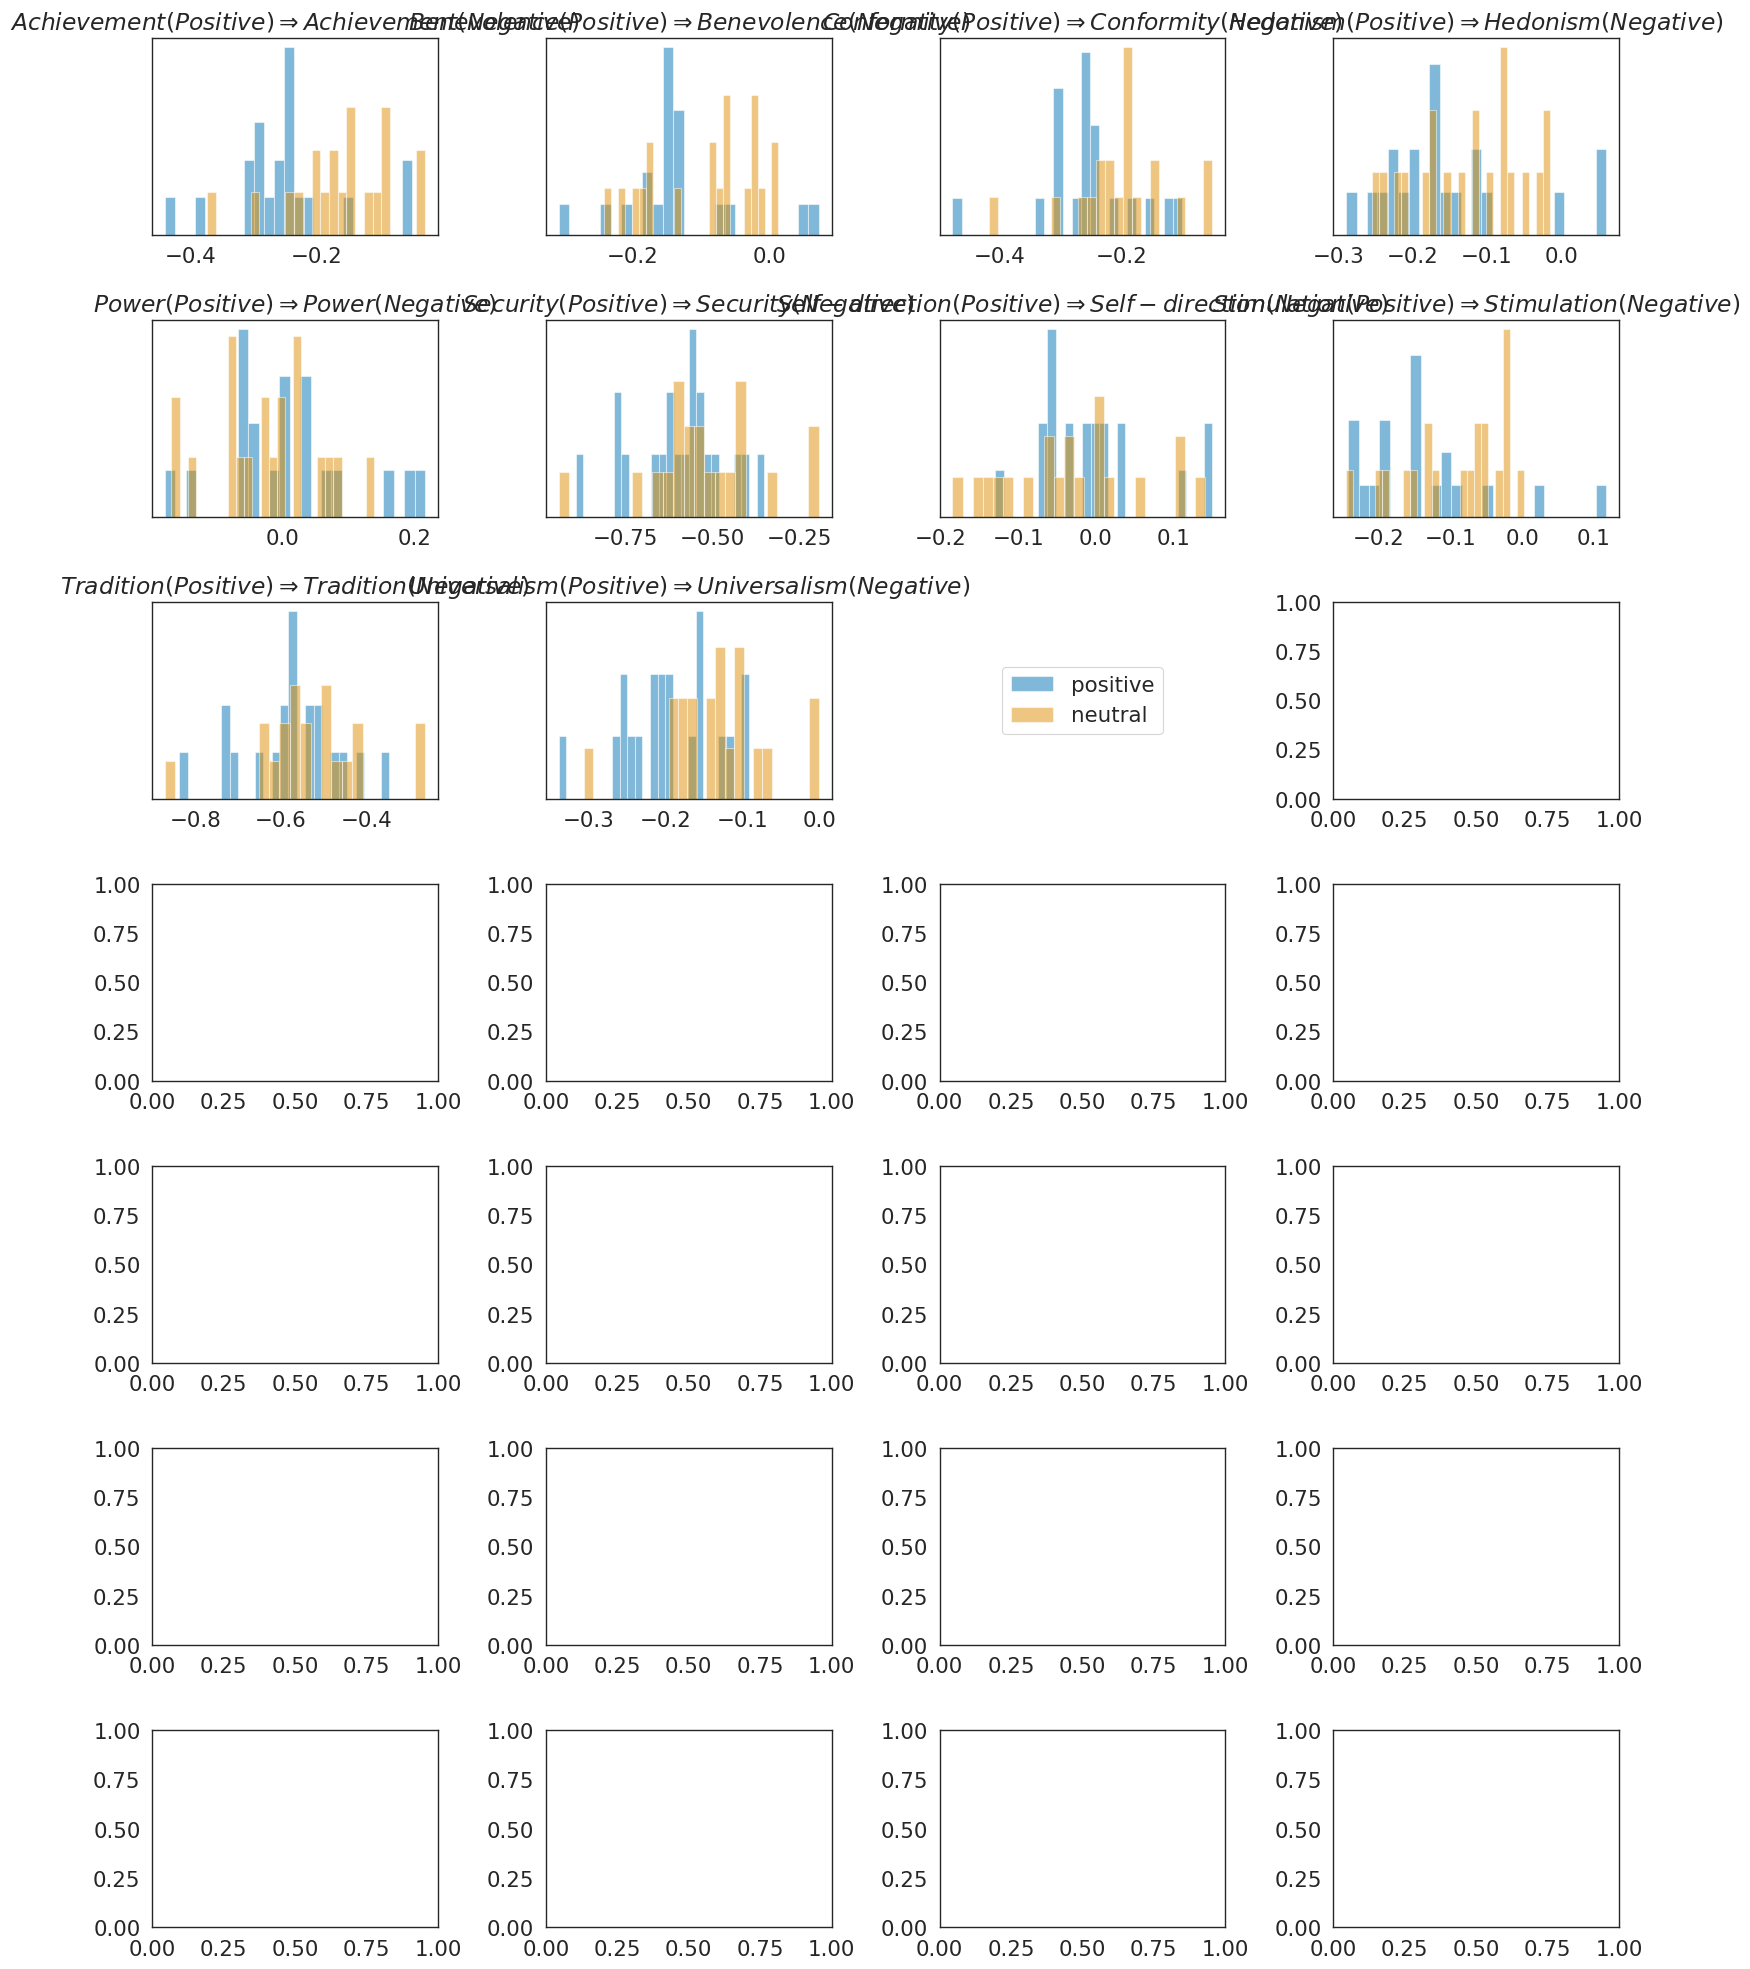

In [13]:
lrg.hist_measurement(lambda_0 @ sqrt_Cov_gamma, lambda_1 @ sqrt_Cov_gamma, concept_g,
                    concept_names, base = "positive", target = "neutral", alpha = 0.5)